# 7. 합성곱 신경망 (CNN) 

In [6]:
# 구글 드라이브와 연결
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 7.1 전체 구조

- 이전의 신경망과 같이 계층을 조합하여 만들 수 있음
- 합성곱계층(Convolutional layer)과 풀링계층(Pooling layer)이 등장
- 완전연결층(fully conneted) : 인접하는 계층의 모든 뉴런과 결합된 신경망
- CNN의 구조 (합성곱과 풀링계층 추가)

## 7.2 합성곱 계층

- 패딩, 스트라이드 등 CNN 고유 용어 등장

### 7.2.1 완전연결 계층의 문제점

- 데이터의 형상이 무시됨 : 3차원 데이터를 1차원 데이터로 평탄화해야 함
    - 이미지(3차원)의 형상에는 공간적 정보가 담겨져 있음
    - 공간적으로 가까운 픽셀의 값은 비슷하거나, RGB의 각 채널은 서로 밀접연관 등의 패턴
- CNN의 합성곱계층은 형상을 유지 (3차원데이터 입력 / 출력)
- CNN에서는 합성곱 계층의 입출력 데이터를 특징 맵(feature map)이라고도 함 (입력특징맵 / 출력특징맵)

### 7.2.2 합성곱 연산

- 이미지 처리에서 말하는 필터 연산에 해당
- 예시 : 입력데이터는 세로,가로 방향의 형상가짐 (필터도 마찬가지)
- 입력은 (4,4), 필터는 (3,3), 출력은(2,2)의 형상
- 문헌에따라 필터를 커널이라고 지칭
- 합성곱연산은 필터의 윈도우를 일정 간격 이동해가며 입력데이터에 적용
- 입력과 필터에서 대응하는 원소끼리 곱한 후 그 총합 계산 (단일 곱셈-누산, FMA)

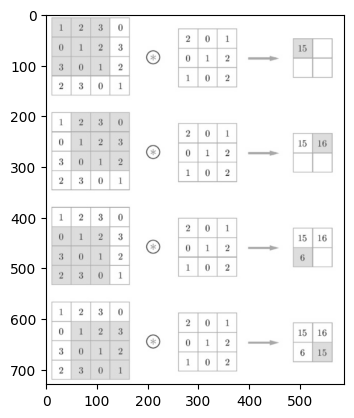

In [7]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/합성곱연산.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- Scipy의 2차원 합성곱함수(scipy.signal.convolved2d)를 이용하면 위의 예시와 다르게 나옴
    - 같은 결과를 얻으려면 교차상관함수(scipy.signal.correlate2d)를 사용해야함
    - 주어진 필터를 플리핑(flipping)하면 합성곱, 그렇지 않으면 교차상관
    - 플리핑 : 원소들을 좌우,상하로 각 한번씩 뒤집는 것
    - 딥러닝 라이브러리들의 합성곱함수들은 플리핑하지 않거나, 플리핑 여부를 인수로 받기도 함

- 편향까지 포함한 합성곱 연산
    - 편향은 항상 하나(1,1)만 존재 = 모든 원소에 더함

### 7.2.3 패딩

- 합성곱 연산을 수행하기 전 입력 데이터 주변을 특정 값 (ex.0)으로 채우는 것
- 예시 : (4,4)크기의 입력데이터에 폭이 1인 패딩 적용 

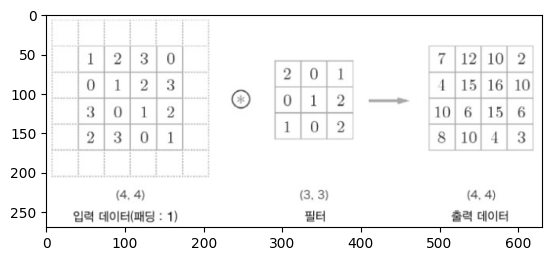

In [8]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/패딩.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- (4,4) 입력데이터에 패딩 추가되어 (6,6)이 됨
- 패딩은 출력크기를 조정할 목적으로 사용
    - 연산을 거칠 때 마다 출력의 형상은 계속해서 줄어들음
    - 출력크기가 1이 되어버리면 합성곱연산 불가
    - 입력데이터의 공간적크기를 고정한 채 다음계층에 전달가능

### 7.2.4 스트라이드

- 필터를 적용하는 위치의 간격
- 스트라이드를 2로 하면 필터적용 윈도우가 두 칸씩 이동

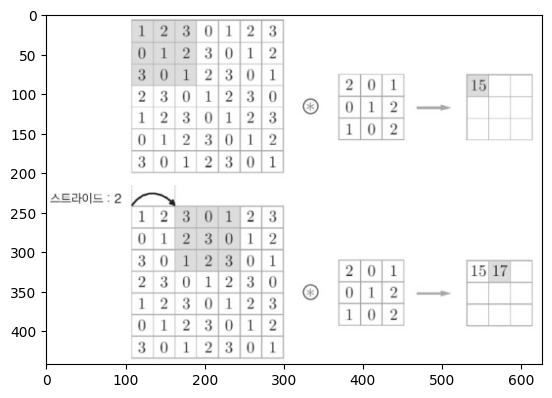

In [9]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/스트라이드.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- 스트라이드를 키우면 출력크기는 작아짐

- 패딩, 스트라이드, 출력크기의 관계 수식화
    - 입력크기(H,W) / 필터크기(FH, FW) / 출력크기(OH, OW) / 패딩 P / 스트라이드 S
    - OH=(H+2P-FH)/S+1
    - OW=(W+2P-FW)/S+1

- 수식들은 정수로 나눠떨어지는 값이어야 함

### 7.2.5 3차원 데이터의 합성곱 연산

- 채널 쪽으로 특징 맵이 여러 개 있을 때
    - 입력데이터와 필터의 합성곱 연산을 채널마다 수행
    - 연산수행 결과 더해서 출력 얻음

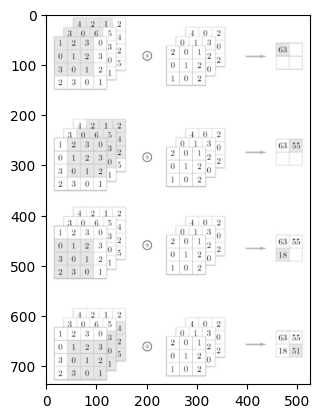

In [10]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/3차원데이터의합성곱연산.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- 입력데이터의 채널 수와 필터의 채널 수가 같아야 함
- 필터 자체 크기는 원하는 값으로 설정가능 (모든 채널의 필터는 같은크기)

### 7.2.6 블록으로 생각하기

- 3차원 직육면체로 생각하면 이해 쉬움

- 3차원 데이터를 배열로 나타낼 때는 채널, 높이, 너비 순서 (C, H, W) / 필터 (C, FH, FW)

- 출력데이터는 한 장의 특징 맵 : 다수의 채널을 내보내려면 필터를 다수 사용

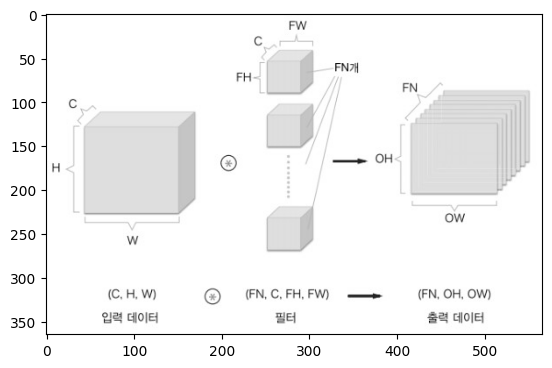

In [11]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/블록으로생각.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- 필터를 FN개 적용하면 출력 맵도 FN개 생성
- FN개의 맵을 모으면 (FN, OH, OW)인 블록 완성
- 합성곱 연산에서는 필터의 수도 고려해야 함
- 필터의 가중치 데이터는 4차원 데이터 (출력채널 수, 입력채널 수, 높이, 너비)
- 편향 추가

### 7.2.7 배치 처리

- 각 계층을 흐르는 데이터의 차원을 하나 늘려 4차원 데이터로 저장
- (데이터 수, 채널 수, 높이, 너비)

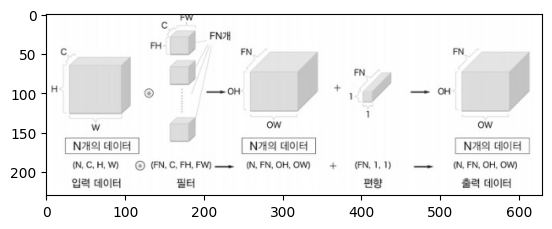

In [12]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/배치처리.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

※ 주의 : 신경망에 4차원 데이터가 하나 흐를 때마다 데이터 N개에 대한 합성곱 연산수행


## 7.3 풀링 계층

- 세로, 가로 방향의 공간을 줄이는 연산
- 최대 풀링(max pooling) : 최댓값을 구하는 연산
- 풀링의 원도우 크기와 스트라이드는 같은 값으로 설정하는 것이 보통
- 최대풀링의 예

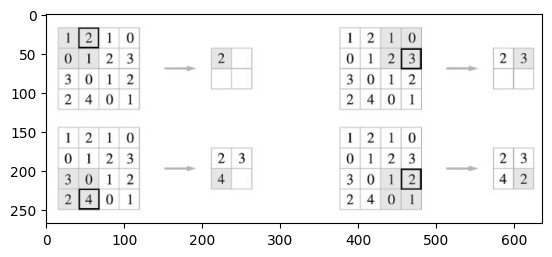

In [13]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_딥러닝/풀링계층.jpg')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

### 7.3.1 풀링 계층의 특징

- 학습해야 할 매개변수가 없다

- 채널 수가 변하지 않는다
    - 풀링연산은 채널마다 독립적으로 계산하기 때문에 입력채널 그대로 출력

- 입력의 변화에 영향을 적게 받는다 (강건하다)
    - 입력 데이터의 차이를 풀링이 흡수해 사라지게 함